In [18]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Python/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.neighbors import KernelDensity
from sklearn.exceptions import NotFittedError
from sklearn import metrics
from matplotlib import pyplot as plt
from tqdm import tqdm

In [0]:
sns.set()

In [0]:
distribution = stats.norm.rvs(size=10_000)

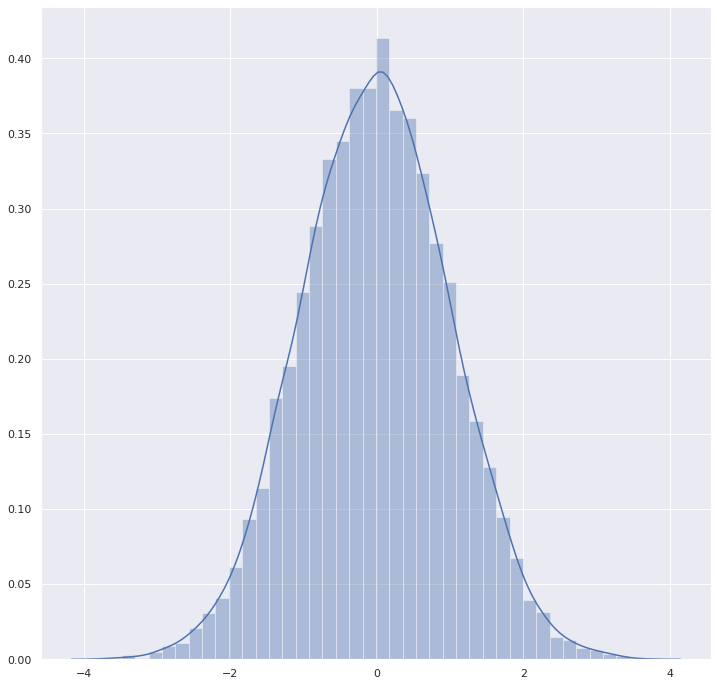

In [0]:
figure = plt.figure(figsize=[12, 12])

sns.distplot(distribution, bins=40)

In [0]:
class ECDF:
    """
    Empirical Cumulative Distribution Function Estimator
    """
    def __init__(self):
        self._density = None

    def _estimate(self, x: float) -> float:
        # np.where works like indicator function
        if self._density is None:
            raise NotFittedError

        return np.sum(np.where(x >= self._density)[0].shape[0]) / self._density.shape[0]

    def fit(self, realization: np.array) -> None:
        """
        :param realization: random variable realization for which
                            cumulative distribution will be estimated,
                            must have at least 2 samples
        """
        self._density = np.sort(realization)

    def predict(self, values: float) -> float:
        """
        Returns cumulative distribution function value at any point

        :param values: value or array of values to compute CDF for

        :raises NotFittedError: when called prior to calling fit function

        :return: array of CDF values
        """
        return np.vectorize(self._estimate)(values)

In [0]:
class Histogram:
    """
    Histogram Probability Density Estimator

    :warning: bins or width must be specified for histogram constructor
    """
    def __init__(self, width: float = None, bins: int = None, normalized: bool = True):
        """
        :param bins: number of bins in histogram
        :param width: width of histogram
        :param normalized: if True values will be divided by number of samples times histogram width
        """
        self._distribution = None
        self._spacing = None
        self.bins = bins
        self.width = width
        self.normalized = normalized

    def fit(self, realization: np.array) -> None:
        """
        :param realization: random variable realization for which
                            probability density  will be estimated,
                            must have at least 2 samples
        """
        self._distribution = realization

        if self.width:
            self._spacing = np.arange(realization.min(), realization.max(), self.width)
            # number of bins is the number of point generated in spacing
            self.bins = self._spacing.shape[0]

        if self.bins:
            self._spacing = np.linspace(realization.min(), realization.max(), self.bins)
            # width is difference between point in spacing
            self.width = self._spacing[1] - self._spacing[0]

    @property
    def normalization_factor(self) -> float:
        """
        :return: normalization factor is (1 / N h),
                 where N is number of samples in fitted distribution and h is histogram width
        """
        if self.normalized:
            return 1.0 / (self.width * self._distribution.shape[0])

        return 1.0

    def _estimate(self, x: float) -> float:
        if self._distribution is None:
            raise NotFittedError

        nearest_value_index = np.abs(self._spacing - x).argmin()  # grid item nearest to called value
        return self.normalization_factor * np.count_nonzero(
            # number of points from distribution between two grid items
            np.logical_and(
                (self._distribution <= self._spacing[nearest_value_index]),
                (self._spacing[nearest_value_index] <= self._distribution + self.width),
            ).astype(np.int)
        )

    def predict(self, values: float) -> float:
        """
        Returns cumulative distribution function value at any point

        :param values: value or array of values to compute histogram for

        :raises NotFittedError: when called prior to calling fit function

        :return: array of histogram values
        """
        return np.vectorize(self._estimate)(values)


In [0]:
estimator = Histogram(width=0.1, normalized=True)

In [0]:
estimator.fit(distribution)

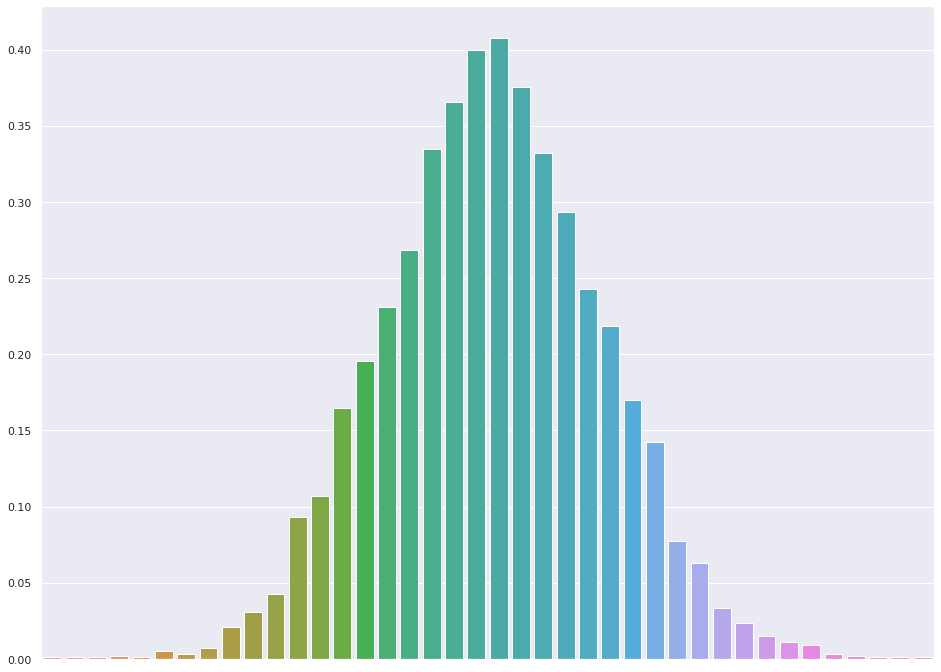

In [112]:
figure = plt.figure(figsize=[16, 12])

x = np.linspace(-4, 4, 40)
plot = sns.barplot(x, estimator.predict(np.linspace(-4, 4, 40)))
_ = plot.set(xticklabels=[])

In [0]:
x = np.linspace(-4, 4, 1000)
real_pdf = stats.norm.pdf(x)
distribtion = stats.norm.rvs(size=1000) 

In [59]:
results = []
for bins in tqdm([2, 4, 8, 12, 16, 24, 32, 64, 100, 200, 500, 1000]):
    hist = Histogram(bins=bins, normalized=True)
    hist.fit(distribtion)
    
    # print(f"N: {hist.bins}\t h: {hist.width} 1/Nh: {hist.normalization_factor}")
    # print(f"MSE: {metrics.mean_squared_error(y_true=real_pdf, y_pred=hist.predict(x))}")
    # print(f"KS: {stats.ks_2samp(real_pdf, hist.predict(x))}", end="\n\n")
    results.append([hist.bins,
                    hist.width,
                    hist.normalization_factor,
                    metrics.mean_squared_error(y_true=real_pdf, y_pred=hist.predict(x)),
                    stats.ks_2samp(real_pdf, hist.predict(x))]
                   )

resutlts_df = pd.DataFrame.from_records(results, columns=["N", "h", "1/NH", "MSE", "KS"])

100%|██████████| 12/12 [00:00<00:00, 29.92it/s]


In [60]:
resutlts_df

,N,h,1/NH,MSE,KS
0,2,6.544730,0.000153,0.032386,"(0.538, 5.912412173900004e-133)"
1,4,2.181577,0.000458,0.022743,"(0.193, 1.0722063786469485e-16)"
2,8,0.934961,0.001070,0.005139,"(0.14, 5.822752148022591e-09)"
3,12,0.594975,0.001681,0.002540,"(0.174, 1.2354887717127082e-13)"
4,16,0.436315,0.002292,0.001821,"(0.198, 1.4811534595157654e-17)"
5,24,0.284553,0.003514,0.001250,"(0.232, 5.287262655536692e-24)"
6,32,0.211120,0.004737,0.001029,"(0.23, 1.354199288211322e-23)"
7,64,0.103885,0.009626,0.001111,"(0.227, 5.463699054715322e-23)"
8,100,0.066108,0.015127,0.001842,"(0.229, 2.1603957516211753e-23)"
9,200,0.032888,0.030406,0.003751,"(0.244, 1.5679195140192733e-26)"


In [84]:
results = []
for bins in tqdm(np.linspace(2, 400, 80)):
    hist = Histogram(bins=int(bins), normalized=True)
    hist.fit(distribtion)
    
    # print(f"N: {hist.bins}\t h: {hist.width} 1/Nh: {hist.normalization_factor}")
    # print(f"MSE: {metrics.mean_squared_error(y_true=real_pdf, y_pred=hist.predict(x))}")
    # print(f"KS: {stats.ks_2samp(real_pdf, hist.predict(x))}", end="\n\n")
    results.append([hist.bins, metrics.mean_squared_error(y_true=real_pdf, y_pred=hist.predict(x))])

100%|██████████| 80/80 [00:01<00:00, 62.04it/s]


In [0]:
results=np.array(results)

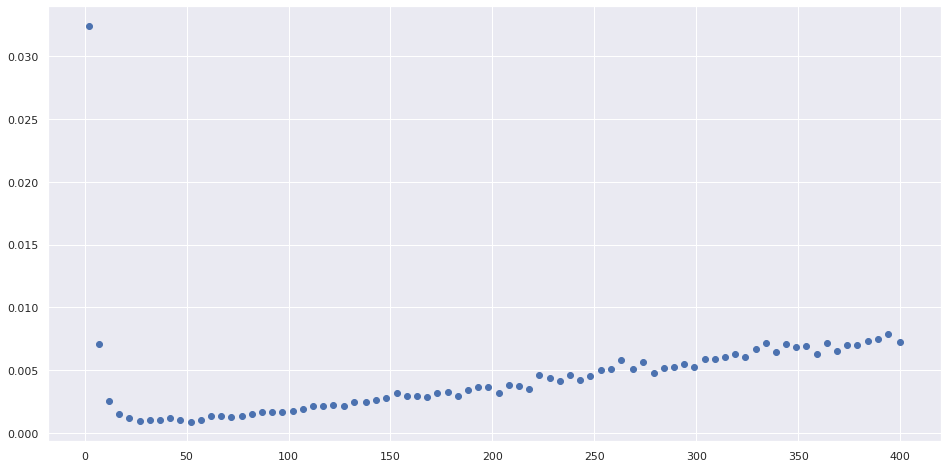

In [100]:
figure = plt.figure(figsize=[16, 8])

plt.scatter(results[:,0], results[:, 1])

In [107]:
for bins in np.arange(10, 20):
    hist = Histogram(bins=bins, normalized=True)
    hist.fit(distribtion)
    print(f"N: {hist.bins} h: {hist.width}")

N: 10 h: 0.7271922266984454
N: 11 h: 0.6544730040286009
N: 12 h: 0.594975458207819
N: 13 h: 0.5453941700238341
N: 14 h: 0.503440772329693
N: 15 h: 0.4674807171632862
N: 16 h: 0.43631533601906725
N: 17 h: 0.40904562751787577
N: 18 h: 0.38498412001682425
N: 19 h: 0.3635961133492227


In [114]:
results = []
x = np.linspace(-4, 4, 1000)

for n_samples in tqdm([10, 50, 100, 200, 500, 1000, 2000, 10000]):
    distribution = stats.norm.rvs(size=n_samples)

    hist = Histogram(bins=int(np.sqrt(n_samples)), normalized=True)
    hist.fit(distribtion)

    results.append([hist.bins,
                    hist.width,
                    hist.normalization_factor,
                    metrics.mean_squared_error(y_true=real_pdf, y_pred=hist.predict(x)),
                    stats.ks_2samp(real_pdf, hist.predict(x))]
                   )

resutlts_df = pd.DataFrame.from_records(results, columns=["N", "h", "1/NH", "MSE", "KS"])

100%|██████████| 8/8 [00:00<00:00, 30.30it/s]


In [115]:
resutlts_df

,N,h,1/NH,MSE,KS
0,3,3.272365,0.000306,0.011157,"(0.304, 3.5000098011524194e-41)"
1,7,1.090788,0.000917,0.007063,"(0.13, 8.797089063129894e-08)"
2,10,0.727192,0.001375,0.003531,"(0.158, 2.6255784492506013e-11)"
3,14,0.503441,0.001986,0.002045,"(0.186, 1.5702401851850447e-15)"
4,22,0.311654,0.003209,0.001181,"(0.224, 2.162984997510718e-22)"
5,31,0.218158,0.004584,0.001029,"(0.226, 8.66144540069212e-23)"
6,44,0.152203,0.006570,0.001206,"(0.227, 5.463699054715322e-23)"
7,100,0.066108,0.015127,0.001842,"(0.229, 2.1603957516211753e-23)"
